# Challenge - Tweets analysis

![](https://images.unsplash.com/photo-1569285645462-a3f9c6332d56?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1050&q=80)

This data originally came from Crowdflower's [Data for Everyone library](http://www.crowdflower.com/data-for-everyone).

As the original source says,

> We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked which candidate was mentioned, and what the sentiment was for a given tweet. 

In this exercise, you will use your NLP and ML tools to **predict the sentiment of a tweet**. This is a project where you are free to explore and use the techniques that you know on the given dataset.

Some potential guidelines :
- Be careful to thourougly explore the data and gain insights about it.
- Practice some topic modelling on the text of the tweets.
- Use the NLP tools that you know on the text of each tweet to make predictions about the sentiment of the tweet.
- Try some feature engineering to improve the performance of your model.

The dataset is located in the `input` folder.

In [91]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [92]:
data = pd.read_csv('../input/Sentiment.csv', index_col='id')

In [93]:
data

,Unnamed: 0,candidate,sentiment,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
id,,,,,,,,,,,
1,0,No candidate mentioned,Neutral,I_Am_Kenzi,5,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
2,1,Scott Walker,Positive,PeacefulQuest,26,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
3,2,No candidate mentioned,Neutral,PussssyCroook,27,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
4,3,No candidate mentioned,Positive,MattFromTexas31,138,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
5,4,Donald Trump,Positive,sharonDay5,156,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona
...,...,...,...,...,...,...,...,...,...,...,...
13867,13866,No candidate mentioned,Negative,SantoliDonato,7,RT @cappy_yarbrough: Love to see men who will ...,NaN,2015-08-07 09:29:43 -0700,629690895479250944,Como,NaN
13868,13867,Mike Huckabee,Positive,mhfa16hq,1,RT @georgehenryw: Who thought Huckabee exceede...,NaN,2015-08-07 09:25:02 -0700,629689719056568320,USA,NaN
13869,13868,Ted Cruz,Positive,DrottM,67,"RT @Lrihendry: #TedCruz As President, I will a...",NaN,2015-08-07 07:19:18 -0700,629658075784282112,NaN,NaN


In [94]:
data.text[2]

"RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…"

In [95]:
data = data.iloc[:,1:]

In [96]:
data.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

In [97]:
X = data[['candidate', 'retweet_count', 'text']]
y = data.sentiment

In [98]:
X.candidate.value_counts()

No candidate mentioned    7491
Donald Trump              2813
Jeb Bush                   705
Ted Cruz                   637
Ben Carson                 404
Mike Huckabee              393
Chris Christie             293
Marco Rubio                275
Rand Paul                  263
Scott Walker               259
John Kasich                242
Name: candidate, dtype: int64

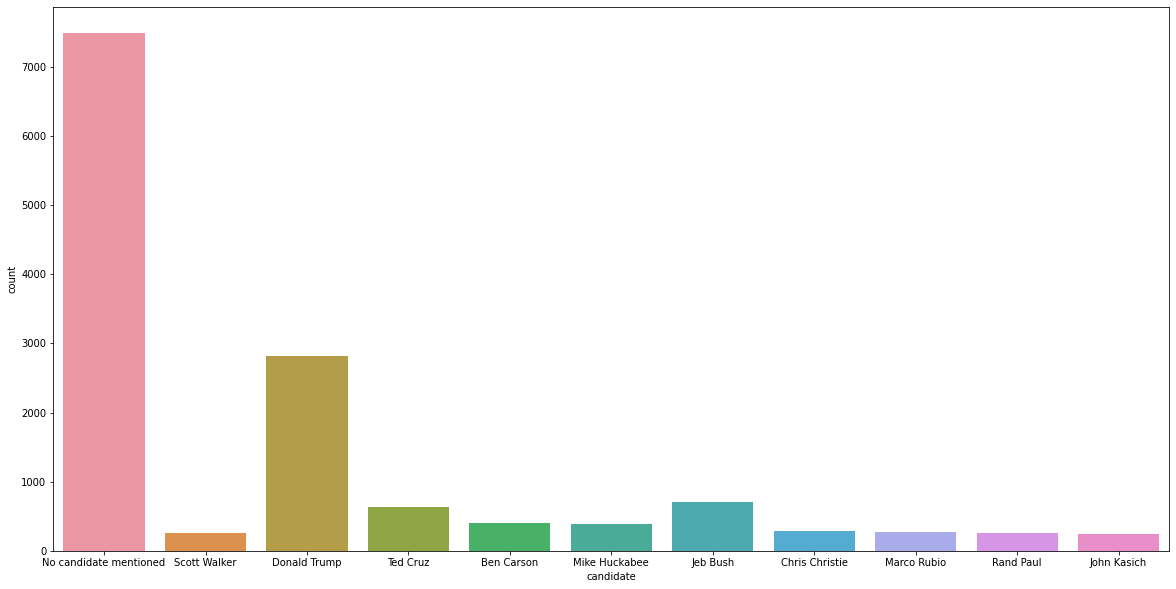

In [99]:
plt.figure(figsize=(20,10))
sns.countplot(x=X.candidate)
plt.show()

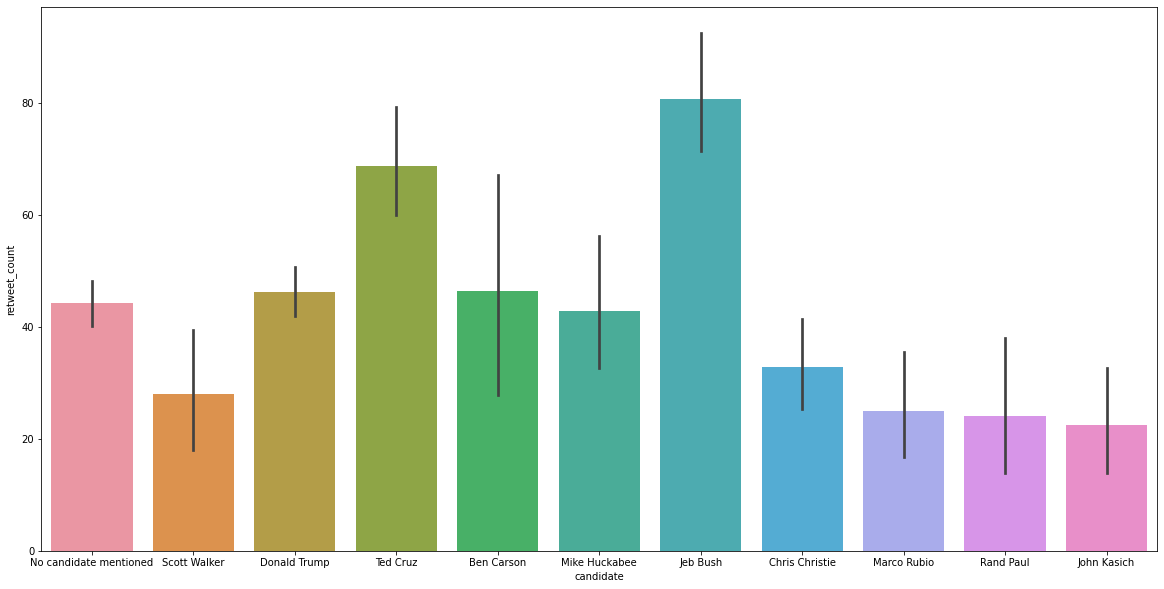

In [100]:
plt.figure(figsize=(20,10))
sns.barplot(x=X.candidate, y=X.retweet_count)
plt.show()

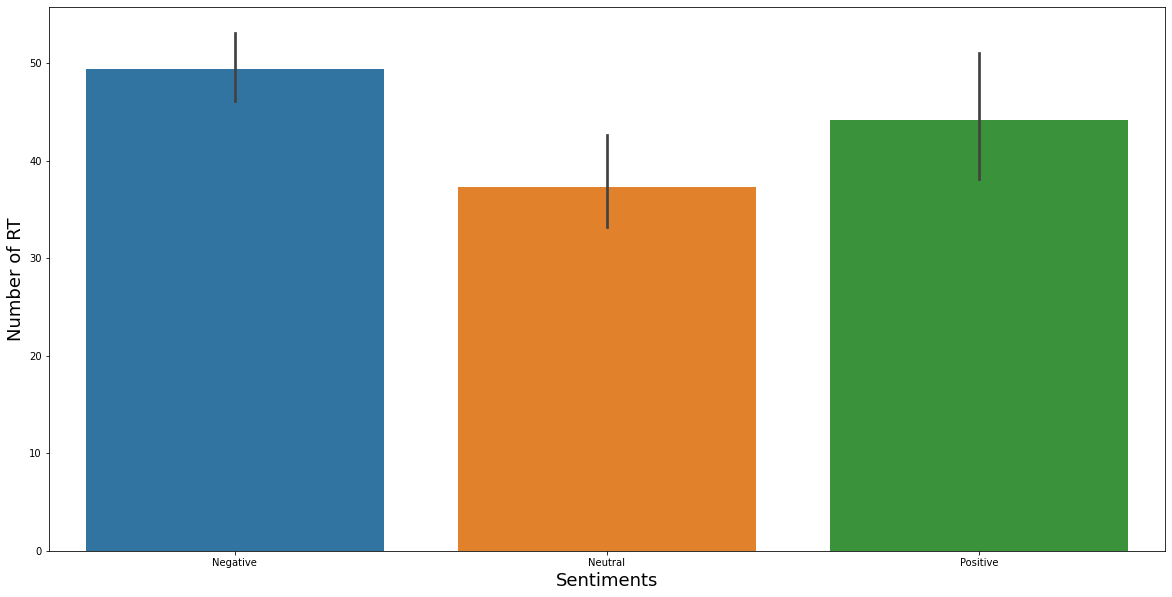

In [101]:
plt.figure(figsize=(20,10))
sns.barplot(x=y, y=X.retweet_count, order=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Sentiments', fontdict={'size':18})
plt.ylabel('Number of RT', fontdict={'size':18})
plt.show()

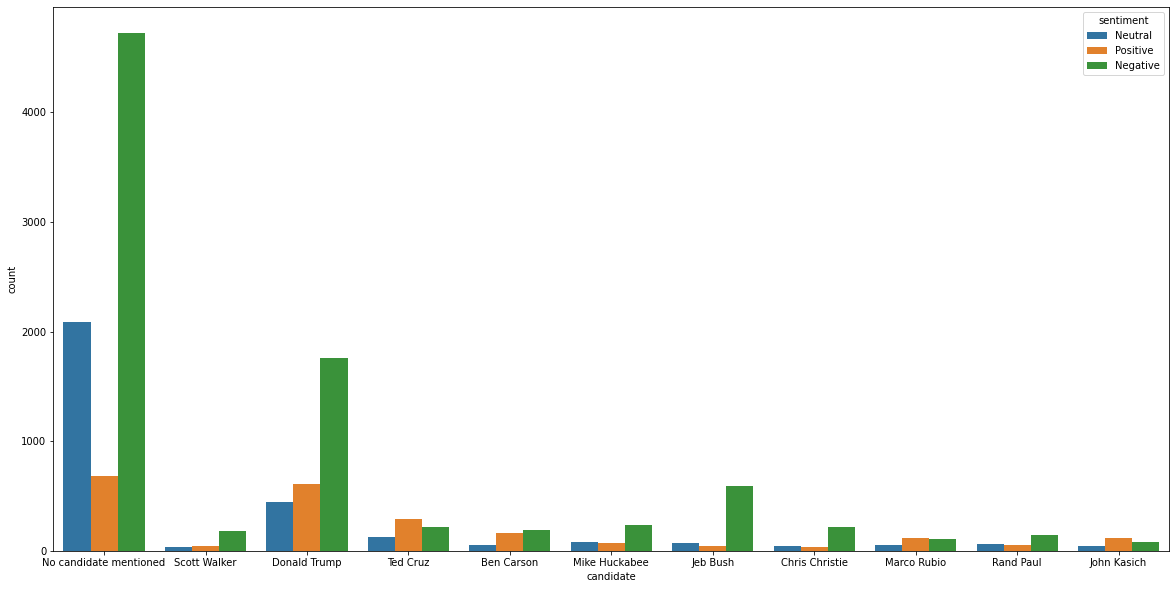

In [102]:
plt.figure(figsize=(20,10))
sns.countplot(x=X.candidate, hue=y)
plt.show()

## Let's deal with the tweets

In [103]:
tweets = X.text

In [104]:
#Def a function to map nltk pos-tags with WordNet pos-tags

from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    output = np.asarray(pos_tag)
    for i in range(len(pos_tag)):
        if pos_tag[i][1].startswith('J'):
            output[i][1] = wordnet.ADJ
        elif pos_tag[i][1].startswith('V'):
            output[i][1] = wordnet.VERB
        elif pos_tag[i][1].startswith('R'):
            output[i][1] = wordnet.ADV
        else:
            output[i][1] = wordnet.NOUN
    return output

In [105]:
def tweet_preproc(text):
    text = re.sub('RT', '', text)
    text = re.sub('@\w+', '', text)
    text = re.sub('#', '', text)
    text = re.sub('http\S+', '', text)
    tokens = word_tokenize(text.lower())
    pos_tags = nltk.pos_tag(tokens)
    tags = get_wordnet_pos(pos_tags)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(tokens[i], tags[i, 1]) for i in range(len(tokens)) if tokens[i].isalpha() and tokens[i] not in stop]
    return tokens

In [106]:
tweets_proc = tweets.apply(tweet_preproc)

## Test sentiment analysis with TextBlob

In [110]:
def sentiment_analysis(texts, max_neg=0, min_pos=0):
    pol = [TextBlob(text).sentiment.polarity for text in texts]
    return pol

In [111]:
pol = sentiment_analysis(X.text)

In [112]:
for i in range(len(pol)):
    if pol[i] < 0.3:
        pol[i] = 'Negative'
    elif pol[i] > 0.5:
        pol[i] = 'Positive'
    else:
        pol[i] = 'Neutral'

In [113]:
pol

['Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Neutral',
 'Neutral',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Neutral',
 'Positive',
 'Negative',
 'Neutral',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Neutral',
 'Negative',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Nega

In [114]:
(pol == y).mean()

0.5852498017446471

## Topic Modelling

### >> To do <<

## Let's try with a multinomial Logistic Regression

In [115]:
X = pd.concat([X.drop('text', axis=1), tweets_proc], axis=1)

In [116]:
X

,candidate,retweet_count,text
id,,,
1,No candidate mentioned,5,"[everyone, feel, climate, change, question, la..."
2,Scott Walker,26,"[catch, full, gopdebate, last, night, scott, b..."
3,No candidate mentioned,27,"[mention, tamir, rice, gopdebate, hold, clevel..."
4,No candidate mentioned,138,"[carly, fiorina, trend, hour, debate, men, gop..."
5,Donald Trump,156,"[gopdebate, deliver, high, rating, history, pr..."
...,...,...,...
13867,No candidate mentioned,7,"[love, see, men, never, face, pregnancy, talk,..."
13868,Mike Huckabee,1,"[think, huckabee, exceed, expectation, gopdeba..."
13869,Ted Cruz,67,"[tedcruz, president, always, tell, truth, say,..."


In [117]:
y

id
1         Neutral
2        Positive
3         Neutral
4        Positive
5        Positive
           ...   
13867    Negative
13868    Positive
13869    Positive
13870    Negative
13871    Positive
Name: sentiment, Length: 13871, dtype: object

In [118]:
dummy_candidates = pd.get_dummies(X.candidate, drop_first=True)

In [119]:
dummy_candidates

,Chris Christie,Donald Trump,Jeb Bush,John Kasich,Marco Rubio,Mike Huckabee,No candidate mentioned,Rand Paul,Scott Walker,Ted Cruz
id,,,,,,,,,,
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
5,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13867,0,0,0,0,0,0,1,0,0,0
13868,0,0,0,0,0,1,0,0,0,0
13869,0,0,0,0,0,0,0,0,0,1


In [120]:
X = pd.concat([X.drop('candidate', axis=1), dummy_candidates], axis=1)

In [121]:
X

,retweet_count,text,Chris Christie,Donald Trump,Jeb Bush,John Kasich,Marco Rubio,Mike Huckabee,No candidate mentioned,Rand Paul,Scott Walker,Ted Cruz
id,,,,,,,,,,,,
1,5,"[everyone, feel, climate, change, question, la...",0,0,0,0,0,0,1,0,0,0
2,26,"[catch, full, gopdebate, last, night, scott, b...",0,0,0,0,0,0,0,0,1,0
3,27,"[mention, tamir, rice, gopdebate, hold, clevel...",0,0,0,0,0,0,1,0,0,0
4,138,"[carly, fiorina, trend, hour, debate, men, gop...",0,0,0,0,0,0,1,0,0,0
5,156,"[gopdebate, deliver, high, rating, history, pr...",0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
13867,7,"[love, see, men, never, face, pregnancy, talk,...",0,0,0,0,0,0,1,0,0,0
13868,1,"[think, huckabee, exceed, expectation, gopdeba...",0,0,0,0,0,1,0,0,0,0
13869,67,"[tedcruz, president, always, tell, truth, say,...",0,0,0,0,0,0,0,0,0,1


In [122]:
from sklearn.model_selection import train_test_split

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify = y)

In [124]:
X_train.shape

(11096, 12)

In [125]:
X_test.shape

(2775, 12)

In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [127]:
vectorizer = TfidfVectorizer(analyzer=lambda x: x)

In [128]:
tfidf_train = vectorizer.fit_transform(X_train.text).toarray()

In [129]:
tfidf_test = vectorizer.transform(X_test.text).toarray()

In [169]:
new_X_train = pd.concat([X_train.drop('text', axis=1).reset_index(), pd.DataFrame(tfidf_train)], axis=1)

In [170]:
new_X_train.drop('id', axis=1, inplace=True)

In [171]:
new_X_test= pd.concat([X_test.drop('text', axis=1).reset_index(), pd.DataFrame(tfidf_test)], axis=1)

In [172]:
new_X_test.drop('id', axis=1, inplace=True)

In [173]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
new_X_train.retweet_count = scaler.fit_transform(np.array(new_X_train.retweet_count).reshape(-1,1))

In [174]:
new_X_test.retweet_count = scaler.fit_transform(np.array(new_X_test.retweet_count).reshape(-1,1))

In [187]:
from sklearn.decomposition import PCA

In [188]:
pca = PCA(n_components=.99) 

In [189]:
pca.fit(new_X_train)

PCA(n_components=0.99)

In [190]:
new_X_train_red = pca.transform(new_X_train)

In [191]:
new_X_test_red = pca.transform(new_X_test)

In [192]:
from sklearn.linear_model import LogisticRegression

In [193]:
lr = LogisticRegression(penalty= 'l2', solver='newton-cg', class_weight='balanced')

In [194]:
lr.fit(new_X_train_red, y_train)

LogisticRegression(class_weight='balanced', solver='newton-cg')

In [195]:
y_pred = lr.predict(new_X_test_red)

In [196]:
from sklearn.metrics import accuracy_score

In [197]:
accuracy_score(y_test, y_pred)

0.6421621621621622

In [198]:
y_pred

array(['Negative', 'Positive', 'Negative', ..., 'Neutral', 'Positive',
       'Negative'], dtype=object)

In [199]:
y_pred_train = lr.predict(new_X_train_red)

In [200]:
from sklearn.metrics import classification_report

In [201]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.83      0.67      0.74      1699
     Neutral       0.44      0.56      0.50       629
    Positive       0.48      0.65      0.55       447

    accuracy                           0.64      2775
   macro avg       0.58      0.63      0.60      2775
weighted avg       0.69      0.64      0.66      2775



In [202]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

    Negative       0.93      0.75      0.83      6794
     Neutral       0.62      0.77      0.69      2513
    Positive       0.62      0.85      0.71      1789

    accuracy                           0.77     11096
   macro avg       0.72      0.79      0.74     11096
weighted avg       0.81      0.77      0.78     11096

